In [2]:
import argparse
import gc
import logging
import os

import sys
# sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')


import time

from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
torch.backends.cudnn.benchmark = True

from matplotlib import pyplot as plt

from matplotlib import pyplot as plt
from argoverse.map_representation.map_api import ArgoverseMap
from argoverse.data_loading.argoverse_forecasting_loader import ArgoverseForecastingLoader
from argoverse.visualization.visualize_sequences import viz_sequence
avm = ArgoverseMap()

num = 10

/home/vikrant/core/home/R/goal/baselines/deep_prediction/argoverse-api/argoverse/map_representation/map_api.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  lane_polygons = np.array(self.get_vector_map_lane_polygons(city_name))
/home/vikrant/core/home/R/goal/baselines/deep_prediction/argoverse-api/argoverse/map_representation/map_api.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  driveable_areas = np.array(self.get_vector_map_driveable_areas(city_name))


In [4]:
predictions = np.load('/home/vikrant/core/home/R/goal/code/prediction.npy', allow_pickle=True)

In [5]:
gt = np.load('/datasets/argoverse/val_data.npy', allow_pickle=True)

In [6]:
import os
import sys
sys.path.append("../ddn/")
sys.path.append("./")
import warnings
warnings.filterwarnings('ignore')

import torch
import numpy as np
import scipy.special
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from scipy.linalg import block_diag
from torch.utils.data import Dataset, DataLoader
#from bernstein import bernstesin_coeff_order10_new

from argoverse.map_representation.map_api import ArgoverseMap
from argoverse.data_loading.argoverse_forecasting_loader import ArgoverseForecastingLoader
from argoverse.visualization.visualize_sequences import viz_sequence
avm = ArgoverseMap()

def denoise(gt_x, gt_y, w = 7):
    # denoising
    gt_x_t = []
    gt_y_t = []
    for iq in range(len(gt_x)):
        if iq >= w and iq + w <= len(gt_x):
            gt_x_t.append(np.mean(gt_x[iq: iq + w]))
            gt_y_t.append(np.mean(gt_y[iq: iq + w]))
        elif iq < w:
            okx = np.mean(gt_x[w: w + w])
            gt_x_t.append(gt_x[0] + (okx - gt_x[0]) * (iq) / w)
            oky = np.mean(gt_y[w: w + w])
            gt_y_t.append(gt_y[0] + (oky - gt_y[0]) * (iq) / w)
        else:
            okx = np.mean(gt_x[len(gt_x) - w:len(gt_x) - w  + w])
            oky = np.mean(gt_y[len(gt_x) - w: len(gt_x) - w + w])
            gt_x_t.append(okx + (gt_x[-1] - okx) * (w - (len(gt_x) - iq)) / w)
            gt_y_t.append(oky + (gt_y[-1] - oky) * (w - (len(gt_y) - iq)) / w)                   

    gt_x = gt_x_t
    gt_y = gt_y_t
    return gt_x, gt_y

def rotate(gt_x, gt_y,theta):
    gt_x_x = [ (gt_x[k] * np.cos(theta) - gt_y[k] * np.sin(theta))  for k in range(len(gt_x))]
    gt_y_y = [ (gt_x[k] * np.sin(theta) + gt_y[k] * np.cos(theta))  for k in range(len(gt_x))]
    gt_x = gt_x_x
    gt_y = gt_y_y
    return gt_x, gt_y

class ArgoverseDataset(Dataset):
    def __init__(self, data_path, t_obs=16, dt=0.125,centerline_dir=None, include_centerline = False, flatten=True):
        self.data = np.load(data_path, allow_pickle=True)
        self.data_path = data_path
        self.t_obs = t_obs
        self.dt = dt
        self.include_centerline = include_centerline
        self.centerline_dir = centerline_dir
        self.flatten = flatten
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        dt = self.dt
        traj = self.data[idx]
        x_traj = traj[:, 0]
        y_traj = traj[:, 1]
                
        x_traj -= x_traj[0]
        y_traj -= y_traj[0]
        
        gt_x = x_traj
        gt_y = y_traj
        
        gt_x, gt_y = denoise(gt_x, gt_y)
        v_x = [ (gt_x[k + 1] - gt_x[k])/dt  for k in range(len(gt_x) - 1)]
        v_y = [ (gt_y[k + 1] - gt_y[k])/dt  for k in range(len(gt_y) - 1)]
        psi = [ np.arctan2(v_y[k], v_x[k]) for k in range(len(v_x))]  
        
        # till here, gt-> (50, 1), v -> (49, 1), psi -> (31, 1)
        
        # obtain this -psi
        theta = -psi[self.t_obs - 1]
        
        # rotate by theta
        gt_x, gt_y = rotate(gt_x, gt_y, theta)
        v_x = [ (gt_x[k + 1] - gt_x[k])/dt  for k in range(len(gt_x) - 1)]
        v_y = [ (gt_y[k + 1] - gt_y[k])/dt  for k in range(len(gt_y) - 1)]
        psi = [ np.arctan2(v_y[k], v_x[k]) for k in range(len(v_x))]
        psidot = [ (psi[k + 1] - psi[k])/dt for k in range(len(psi) - 1) ]
        psi_traj = [i.item() for i in psi]
        psidot_traj = [i.item() for i in psidot]
        
        x_traj = gt_x
        y_traj = gt_y

        x_inp = x_traj[:self.t_obs]
        y_inp = y_traj[:self.t_obs]
        x_fut = x_traj[self.t_obs:]
        y_fut = y_traj[self.t_obs:]

        # till here, gt-> (32, 1), v -> (31, 1), psi -> (31, 1), psidot -> (30, 1)
        psi_fut = psi_traj[self.t_obs - 1:]
        psidot_fut = psi_traj[self.t_obs - 2:]
        
        vx_traj = v_x
        vy_traj = v_y
        
        vx_beg = vx_traj[self.t_obs]
        vy_beg = vy_traj[self.t_obs]
        
        vx_beg_prev = vx_traj[self.t_obs - 1]
        vy_beg_prev = vy_traj[self.t_obs - 1]
        
        ax_beg = (vx_beg - vx_beg_prev) / self.dt
        ay_beg = (vy_beg - vy_beg_prev) / self.dt

        vx_fin = v_x[-1]
        vy_fin = v_y[-1]
        
        vx_fin_prev = v_x[-2]
        vy_fin_prev = v_y[-2]

        ax_fin = (vx_fin - vx_fin_prev) / self.dt
        ay_fin = (vy_fin - vy_fin_prev) / self.dt

        x_fut = x_traj[self.t_obs:]
        y_fut = y_traj[self.t_obs:]
        
        if self.flatten:
            traj_inp = np.dstack((x_inp, y_inp)).flatten()  
        else:
            traj_inp = np.vstack((x_inp, y_inp))
            traj_inp = np.swapaxes(traj_inp, 0, 1)

        vx_fut = vx_traj[self.t_obs:]
        vy_fut = vy_traj[self.t_obs:]
        traj_out = np.hstack((x_fut, y_fut)).flatten()

        fixed_params = np.array([x_fut[0], y_fut[0], 0, psi_fut[0], psidot_fut[0]])
        var_inp = np.array([x_inp[-1], y_inp[-1], psi_fut[-1]])

        return torch.tensor(traj_inp), torch.tensor(traj_out), torch.tensor(fixed_params), torch.tensor(var_inp)

In [7]:
train_dataset = ArgoverseDataset("/datasets/argoverse/val_data.npy", centerline_dir="/datasets/argoverse/val_centerlines.npy", t_obs=20, dt=0.3, include_centerline = False)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=False, num_workers=0)

In [8]:
import pandas as pd
data_ = pd.read_pickle('/datasets/argoverse/forecasting_features_val.pkl')
features = data_["FEATURES"].values
features[0].shape

(50, 11)

In [ ]:
# files = Path("/datasets/argoverse/val/data/").rglob("*.csv")
# all_csvs = [pd.read_csv(file) for file in files]
# print(len(all_csvs))

In [29]:
from argoverse.map_representation.map_api import ArgoverseMap
from argoverse.data_loading.argoverse_forecasting_loader import ArgoverseForecastingLoader
from argoverse.visualization.visualize_sequences import viz_sequence

for batch_num, data in enumerate(train_loader):
    traj_inp, traj_out, fixed_params, var_inp = data
    print(traj_inp.shape, traj_out.shape)
    
    for ii in range(1):
        avm = ArgoverseMap()
        dt = 0.3
        t_obs = 20
        idx = ii + batch_num * 512
        traj = gt[idx]
        x_traj = traj[:, 0]
        y_traj = traj[:, 1]

        x_traj -= x_traj[0]
        y_traj -= y_traj[0]

        gt_x = x_traj
        gt_y = y_traj

        gt_x, gt_y = denoise(gt_x, gt_y)
        v_x = [ (gt_x[k + 1] - gt_x[k])/dt  for k in range(len(gt_x) - 1)]
        v_y = [ (gt_y[k + 1] - gt_y[k])/dt  for k in range(len(gt_y) - 1)]
        psi = [ np.arctan2(v_y[k], v_x[k]) for k in range(len(v_x))]  

        # till here, gt-> (50, 1), v -> (49, 1), psi -> (31, 1)

        # obtain this -psi
        theta = -psi[t_obs - 1]
    
        fil = "/datasets/argoverse/val/data/" + str(int(1e4 + ii)) + '.csv'
        df = pd.read_csv(fil)
        avdf = df[df['OBJECT_TYPE'] == 'AV']
        avx = df[df['OBJECT_TYPE'] == 'AV']['X'].values
        avy = df[df['OBJECT_TYPE'] == 'AV']['Y'].values
        
        print(avx)

        otherdf = df[df['OBJECT_TYPE'] == 'OTHERS']
        centerlines_data = []
        if True:
            # get offsets
            x_trajf = features[idx][:, 3]
            y_trajf = features[idx][:, 4]

            # get city centerlines
            city = features[idx][0][5]
            seq_lane_props = avm.city_lane_centerlines_dict[city]
            x_max, x_min = np.max(x_trajf) + 50, np.min(x_trajf) - 50
            y_max, y_min = np.max(y_trajf) + 50, np.min(y_trajf) - 50

            lane_centerlines = []            
            for lane_id, lane_props in seq_lane_props.items():
                lane_cl = lane_props.centerline

                if (np.min(lane_cl[:, 0]) < x_max and np.min(lane_cl[:, 1]) < y_max and np.max(lane_cl[:, 0]) > x_min and np.max(lane_cl[:, 1]) > y_min):
                    lane_centerlines.append(lane_cl)

            clx = []
            cly = []
            for lane_cl in lane_centerlines:
    #                 plt.plot(lane_cl[:, 0], lane_cl[:, 1], "--", color="grey", alpha=1, linewidth=1, zorder=0)
                c_x = lane_cl[:, 0]
                c_y = lane_cl[:, 1]
                c_x -= x_trajf[0]
                c_y -= y_trajf[0]
#                 avx = [po - x_trajf[0] for po in avx]
#                 avy = [po - y_trajf[0] for po in avy]
                # rotate by theta
                c_x, c_y = rotate(c_x, c_y, theta)
#                 avx, avy = rotate(avx, avy, theta)
                clx.append(c_x)
                cly.append(c_y)
            clx = np.array(clx)
            cly = np.array(cly)
            centerlines = np.array([clx, cly])
            for k in range(centerlines.shape[1]):
                plt.plot(centerlines[0, k, :], centerlines[1, k, :], "--", color="grey", alpha=1, linewidth=1, zorder=0)
        plt.plot(traj_inp[idx, 0::2], traj_inp[idx, 1::2], color='blue', label='observed')
        plt.plot(predictions[0][idx][:30], predictions[0][idx][30:], color='orange', label='predicted')
        plt.plot(traj_out[idx, :30], traj_out[idx, 30:], color='green', label='gt')
#         plt.plot(avx, avy, color='grey', label='AV')
        
        plt.scatter(traj_out[idx, 29], traj_out[idx, 59], color='green', label='gt end-point')
        plt.scatter(predictions[0][idx][29], predictions[0][idx][59], color='orange', label='pred end-point')
        plt.scatter(traj_inp[idx, 38], traj_inp[idx, 39], color='blue')
        
        plt.legend()
        plt.axis('equal')
        plt.savefig('../results/' + str(idx) + '.png')
        plt.clf()
        print(idx)
    break

torch.Size([512, 40]) torch.Size([512, 60])
[390.37361823 390.37365378 390.37378326 390.3736596  390.37365401
 390.37381172 390.37401276 390.37389287 390.37394372 390.3741585
 390.37438786 390.37434528 390.37435324 390.3744306  390.37464984
 390.37470746 390.37448193 390.37448471 390.37468922 390.37481098
 390.37466423 390.3747529  390.3747878  390.37496576 390.37495082
 390.37518377 390.37523812 390.37533104 390.37542976 390.37550049
 390.37539182 390.37520164 390.37552097 390.37515372 390.37529878
 390.37507587 390.37516651 390.37494428 390.37474041 390.37446297
 390.37463575 390.37430779 390.37421683 390.37390424 390.37370056
 390.37386027 390.37345366 390.37353181 390.37316381 390.37311408]
0


<Figure size 432x288 with 0 Axes>

In [6]:
from pathlib import Path
import pandas as pd

2111.762974201896 2058.768453745044
664.6017919155471 624.1210947437952


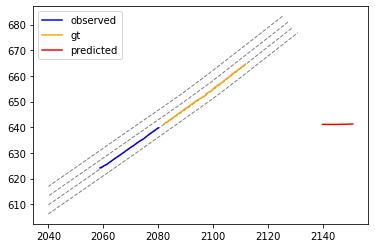

731.6266852083667 730.7826109429393
1473.9975028198678 1454.5526804618066


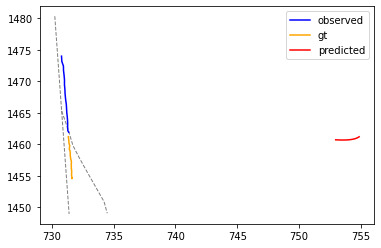

2187.6376249733357 2152.780535229472
724.4250305918488 698.9090198053317


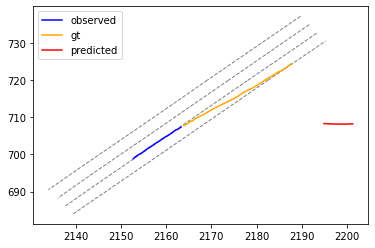

416.5951044828353 415.2773586469266
1161.8324819428942 1128.2040124501618


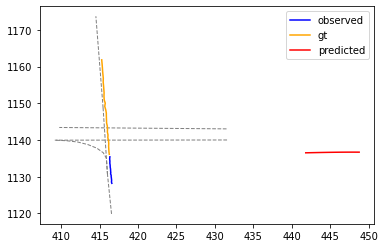

1902.8184857975425 1843.6434365311375
497.7488836779072 447.57938576292855


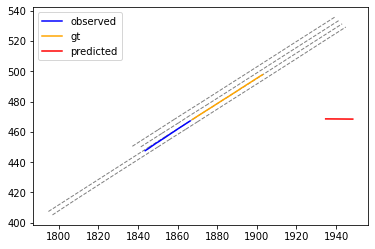

709.9163566123325 702.8559964299627
1170.3643021658604 1156.6889386431842


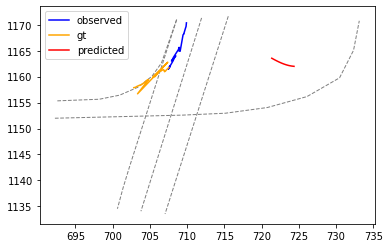

705.8450533318753 698.3600567871597
1156.3817571880638 1123.5248790579542


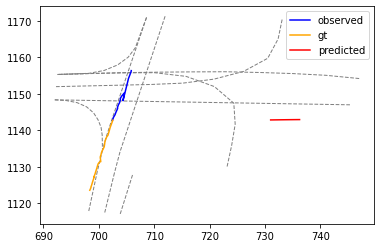

1992.5107036861664 1932.987372290088
575.9351804036646 530.0118602759792


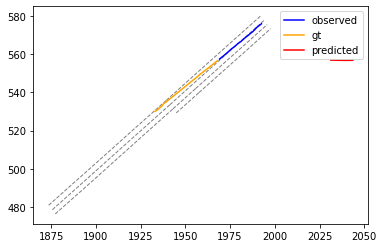

759.8252034016677 735.0127534127803
1388.5710944282987 1376.7616046079145


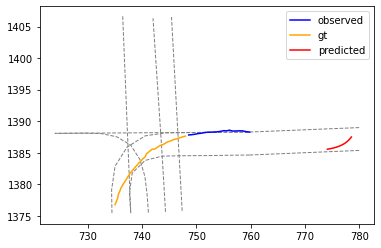

2033.1294074900727 1966.3254760561765
601.3785161570953 551.377264522731


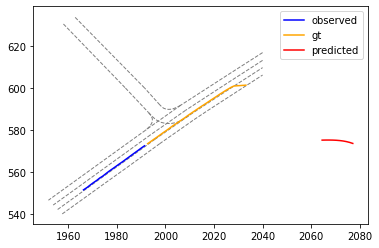

In [6]:
for i in range(num):
    city = features[i][0][5]
    seq_lane_props = avm.city_lane_centerlines_dict[city]
    
    gt_x = features[i][:, 3]
    gt_y = features[i][:, 4]
    
    x_max, y_max = np.max(gt_x) + 50, np.max(gt_y) + 50
    x_min, y_min = np.min(gt_x) - 50, np.min(gt_y) - 50
    print(x_max, x_min)
    print(y_max, y_min)
    
    lane_centerlines = []    
    # Get lane centerlines which lie within the range of trajectories
    for lane_id, lane_props in seq_lane_props.items():
        lane_cl = lane_props.centerline

        if (np.min(lane_cl[:, 0]) < x_max and np.min(lane_cl[:, 1]) < y_max and np.max(lane_cl[:, 0]) > x_min and np.max(lane_cl[:, 1]) > y_min):
            lane_centerlines.append(lane_cl)

    for lane_cl in lane_centerlines:
        plt.plot(lane_cl[:, 0], lane_cl[:, 1], "--", color="grey", alpha=1, linewidth=1, zorder=0)
    
    pred_x = [ gt_x[20] + j for j in np.array(predictions[0])[i, :30]]
    pred_y = [ gt_y[20] + j for j in np.array(predictions[0])[i, 30: ]]
    plt.plot(gt_x[:20], gt_y[:20], color='blue', label='observed')
    plt.plot(gt_x[20:], gt_y[20:], color='orange', label='gt')
    plt.plot(pred_x[20:], pred_y[20:], color='red', label='predicted')
    plt.legend()
    plt.show()
    